# MGL869 - Lab

*MGL869 ETS Montreal - Production engineering*

## Abstract

## Authors
- **Léo FORNOFF**
- **William PHAN**
- **Yannis OUAKRIM**

---

## Part 1 : Data collection

In [21]:
from numpy.random import logistic

from Jira import jira_download
from pandas import Index
from numpy import ndarray


### 1.1 - Download Jira data
We download data if they are not already present in the data folder.

Return the dataframe of the data.

Query filter can be defined in config.ini

In [22]:
jira_dataframe = jira_download()

Data already downloaded
Filter = 'project=HIVE AND issuetype=Bug AND status in (Resolved, Closed) AND affectedVersion>= 2.0.0'


### 1.2 - Clean Jira data using pandas
Previously, we downloaded all the data from Jira. Now, we will clean the data using pandas.
We will keep only some columns and combine some columns.

In [23]:
keep: [str] = ['Issue key', 'Status', 'Resolution', 'Created', 'Fix Versions Combined', 'Affects Versions Combined']

In [24]:
affects_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Affects Version/s')]
jira_dataframe['Affects Versions Combined'] = jira_dataframe[affects_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)

In [25]:
# Combine the versions into a single column
fix_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Fix Version/s')]

jira_dataframe['Fix Versions Combined'] = jira_dataframe[fix_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)
jira_dataframe = jira_dataframe.loc[:, keep]

In [26]:
# Identify columns whose names contain the string 'Issue key'
issue_key_columns: Index = jira_dataframe.columns[jira_dataframe.columns.str.contains('Issue key')]
# Extract the values from these columns as a NumPy array
issue_key_values: ndarray = jira_dataframe[issue_key_columns].values
# Flatten the array to create a one-dimensional list of all 'Issue key' values
flattened_issue_keys: ndarray = issue_key_values.flatten()
# Convert the list into a set to remove duplicates
ids: set = set(flattened_issue_keys)

In [27]:
ids

{'HIVE-13240',
 'HIVE-14074',
 'HIVE-27140',
 'HIVE-21927',
 'HIVE-13144',
 'HIVE-17831',
 'HIVE-17706',
 'HIVE-12315',
 'HIVE-16254',
 'HIVE-24165',
 'HIVE-14607',
 'HIVE-11841',
 'HIVE-12725',
 'HIVE-21917',
 'HIVE-15811',
 'HIVE-13858',
 'HIVE-26658',
 'HIVE-17582',
 'HIVE-17309',
 'HIVE-12635',
 'HIVE-25997',
 'HIVE-18529',
 'HIVE-24848',
 'HIVE-22178',
 'HIVE-18188',
 'HIVE-26633',
 'HIVE-21402',
 'HIVE-15756',
 'HIVE-13929',
 'HIVE-21698',
 'HIVE-22076',
 'HIVE-13458',
 'HIVE-13813',
 'HIVE-24553',
 'HIVE-20112',
 'HIVE-11122',
 'HIVE-14349',
 'HIVE-14076',
 'HIVE-22880',
 'HIVE-14032',
 'HIVE-24595',
 'HIVE-22108',
 'HIVE-22190',
 'HIVE-20182',
 'HIVE-19850',
 'HIVE-21052',
 'HIVE-22982',
 'HIVE-13599',
 'HIVE-16920',
 'HIVE-21811',
 'HIVE-12688',
 'HIVE-21586',
 'HIVE-13779',
 'HIVE-23347',
 'HIVE-19043',
 'HIVE-12786',
 'HIVE-14274',
 'HIVE-12662',
 'HIVE-17098',
 'HIVE-22196',
 'HIVE-21367',
 'HIVE-13837',
 'HIVE-13989',
 'HIVE-11698',
 'HIVE-18069',
 'HIVE-21925',
 'HIVE-131

---


## Part 2 : Repository analysis


In [28]:
from Hive import git_download, commit_analysis, update_commit_dataframe
from git import Repo, Tag
from pandas import DataFrame
from configparser import ConfigParser
from re import compile
from packaging import version

### 2.1 - Clone repository

In [29]:
repo: Repo = git_download()

data\hive_data\hiveRepo False
Pulling the repository: https://github.com/apache/hive.git
Pull failed :  Cmd('git') failed due to: exit code(1)
  cmdline: git pull -v -- origin


In [30]:
all_couples = commit_analysis(ids)

20493 couples found.


### 2.2 - Filter data

In [34]:
commit_dataframe: DataFrame = DataFrame(all_couples, columns=["Issue key", "File", "Commit"])

In [35]:
# Languages without whitespaces
config: ConfigParser = ConfigParser()
config.read("config.ini")
languages: [str] = config["GENERAL"]["Languages"].split(",")
languages: [str] = [lang.strip() for lang in languages]
commit_dataframe: DataFrame = commit_dataframe[commit_dataframe['File'].str.endswith(tuple(languages))]

In [36]:
couples = update_commit_dataframe(commit_dataframe, jira_dataframe)
couples

,Issue key,File,Version Affected
0,HIVE-28239,standalone-metastore/metastore-server/src/main...,4.0.0
1,HIVE-28239,standalone-metastore/metastore-server/src/test...,4.0.0
2,HIVE-28217,jdbc/src/java/org/apache/hive/jdbc/Utils.java,3.1.2
3,HIVE-28217,jdbc/src/test/org/apache/hive/jdbc/TestHiveCon...,3.1.2
4,HIVE-28262,serde/src/java/org/apache/hadoop/hive/serde2/l...,"3.1.3, 4.1.0"
...,...,...,...
10236,HIVE-13932,ql/src/java/org/apache/hadoop/hive/ql/exec/SMB...,"1.0.0, 2.0.0"
10237,HIVE-13904,ql/src/java/org/apache/hadoop/hive/ql/parse/QB...,"2.0.1, 2.1.0, 2.2.0"
10238,HIVE-13599,llap-server/src/java/org/apache/hadoop/hive/ll...,2.1.0
10239,HIVE-13599,llap-server/src/test/org/apache/hadoop/hive/ll...,2.1.0


### 2.3 - Extract filter versions from git

In [13]:
releases_regex: [str] = config["GIT"]["ReleasesRegex"].split(",")
tags: Tag = repo.tags
versions: dict = {tag.name: tag.commit for tag in tags}
releases_regex: [str] = [regex.strip() for regex in releases_regex]
releases_regex = [compile(regex) for regex in releases_regex]

In [14]:
filtered_versions: dict = {}
for version_str in versions:
    if any(regex.match(version_str) for regex in releases_regex):
        version_numbers = version_str.split("-")[1]
        if version.parse(version_numbers) >= version.parse("2.0"):
            filtered_versions[version_numbers] = versions[version_str]

filtered_versions = dict(sorted(
    filtered_versions.items(),
    key=lambda item: item[1].committed_datetime,
    reverse=True
))

filtered_versions, len(filtered_versions)

({'4.0.1': <git.Commit "3af4517eb8cfd9407ad34ed78a0b48b57dfaa264">,
  '2.3.10': <git.Commit "5160d3af392248255f68e41e1e0557eae4d95273">,
  '4.0.0': <git.Commit "183f8cb41d3dbed961ffd27999876468ff06690c">,
  '3.1.3': <git.Commit "4df4d75bf1e16fe0af75aad0b4179c34c07fc975">,
  '2.3.9': <git.Commit "92dd0159f440ca7863be3232f3a683a510a62b9d">,
  '2.3.8': <git.Commit "f1e87137034e4ecbe39a859d4ef44319800016d7">,
  '2.3.7': <git.Commit "cb213d88304034393d68cc31a95be24f5aac62b6">,
  '3.1.2': <git.Commit "8190d2be7b7165effa62bd21b7d60ef81fb0e4af">,
  '2.3.6': <git.Commit "2c2fdd524e8783f6e1f3ef15281cc2d5ed08728f">,
  '2.3.5': <git.Commit "76595628ae13b95162e77bba365fe4d2c60b3f29">,
  '2.3.4': <git.Commit "56acdd2120b9ce6790185c679223b8b5e884aaf2">,
  '3.1.1': <git.Commit "f4e0529634b6231a0072295da48af466cf2f10b7">,
  '3.1.0': <git.Commit "bcc7df95824831a8d2f1524e4048dfc23ab98c19">,
  '3.0.0': <git.Commit "ce61711a5fa54ab34fc74d86d521ecaeea6b072a">,
  '2.3.3': <git.Commit "3f7dde31aed44b5440563d3

## Part 3. - Understand analysis

In [15]:
from Understand.commands import und_create_command, und_purge_command
from Understand.metrics import metrics
from Understand.label import label_all_metrics
from os import path

### 3.1 - Create the Understand project


In [16]:
hive_git_directory: str = config["GIT"]["HiveGitDirectory"]
data_directory: str = config["GENERAL"]["DataDirectory"]
understand_project_name: str = config["UNDERSTAND"]["UnderstandProjectName"]

understand_project_path: str = path.join(data_directory, hive_git_directory, understand_project_name)

if not path.exists(understand_project_path):
    und_create_command()

In [17]:
und_purge_command()

Running command : 
     und purge -db data\hive_data\hive.und
Database purged.



### 3.2 - Metrics extraction


In [18]:
metrics(filtered_versions)

Metrics analysis is skipped as per configuration.


### 3.3 - Labeling


In [20]:
label_all_metrics(couples)

FileNotFoundError: Metrics directory not found: data\metrics_output

## 4 - Model

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from configparser import ConfigParser

from IA_models import load_data, KFold_XY, plot_SHAP, logistic_regression_treatment, random_forest_treatment

### 4.1 - Load data

In [2]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

LABELED_METRICS_OUTPUT_DIRECTORY: str = config["OUTPUT"]["LabeledMetricsOutputDirectory"]
N_SPLITS: int = int(config["IA"]["NSplits"])
SHUFFLE: bool = config["IA"].getboolean("Shuffle")
RANDOM_STATE: int = int(config["IA"]["RandomState"])
N_ESTIMATORS: int = int(config["IA"]["nEstimators"])

data_dict: dict = load_data(LABELED_METRICS_OUTPUT_DIRECTORY)

### 4.2 - Prepare data
The commit version, its ID, and the file name are not considered in the model training. All columns containing a NaN are unusable and removed.

In [3]:
XY_dict: dict = {}
for key in data_dict.keys():
    data: pd.DataFrame = data_dict[key]
    X = data.drop(columns=['BugStatus', 'Name', 'Kind']).dropna(axis=1)  # independent variables
    y = data['BugStatus']  # presence of a bug
    XY_dict[key] = (X, y)

### 4.3 Training and test data
The entire dataset is divided into 10 equal parts on which the model is trained. Validation is performed [using cross-validation](https://medium.com/@tubelwj/five-methods-for-data-splitting-in-machine-learning-27baa50908ed) to more accurately determine the effectiveness of our model.

In [4]:
XY_training_dict: dict = {}
XY_testing_dict: dict = {}
for key in XY_dict.keys():
    X, y = XY_dict[key]
    X_train, X_test, y_train, y_test = KFold_XY(N_SPLITS, SHUFFLE, RANDOM_STATE, X, y)
    XY_training_dict[key] = (X_train, y_train)
    XY_testing_dict[key] = (X_test, y_test)

### 4.4 Model Training

Comparison between logistic regression and random forest.

In [5]:
XY_training_dict.keys()

dict_keys(['2.0.0_labeled_metrics.csv', '2.1.0_labeled_metrics.csv', '2.2.0_labeled_metrics.csv', '2.3.0_labeled_metrics.csv', '3.0.0_labeled_metrics.csv', '3.1.0_labeled_metrics.csv', '4.0.0_labeled_metrics.csv'])

In [6]:
XY_training_dict['2.0.0_labeled_metrics.csv']

(      AvgCountLine  AvgCountLineBlank  AvgCountLineCode  AvgCountLineComment  \
 0             11.0                0.0              11.0                  0.0   
 1             12.0                0.0              11.0                  0.0   
 2             17.0                1.0              14.0                  2.0   
 3              2.0                0.0               2.0                  0.0   
 4             10.0                1.0               8.0                  1.0   
 ...            ...                ...               ...                  ...   
 4483          38.0                0.0              38.0                  0.0   
 4484          44.0                0.0              43.0                  1.0   
 4485           0.0                0.0               0.0                  0.0   
 4486          42.0                0.0              41.0                  0.0   
 4487           0.0                0.0               0.0                  0.0   
 
       AvgCyclomatic  Coun

In [7]:
logistic_regression_models: dict = {}
random_forest_models: dict = {}

for key in XY_training_dict:
    X_train, y_train = XY_training_dict[key]
    log_model = LogisticRegression(max_iter=1000)
    random_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

    log_model.fit(X_train, y_train)
    random_model.fit(X_train, y_train)

    logistic_regression_models[key] = log_model
    random_forest_models[key] = random_model

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-Lab-Hive\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4.5 Prediction

In [8]:
logistic_regression_predictions: dict = {}
random_forest_prediction: dict = {}

for key in XY_testing_dict:
    X_test, y_test = XY_testing_dict[key]
    random_forest_prediction[key] = random_forest_models[key].predict(X_test)
    logistic_regression_predictions[key] = logistic_regression_models[key].predict(X_test)

### 4.6 Evaluate the model performance

The 2 models are compared by their AUC, precision, and recall. The **random forest** is a better model for determining the presence of bugs in a commit.

#### 4.6.1 Random Forest

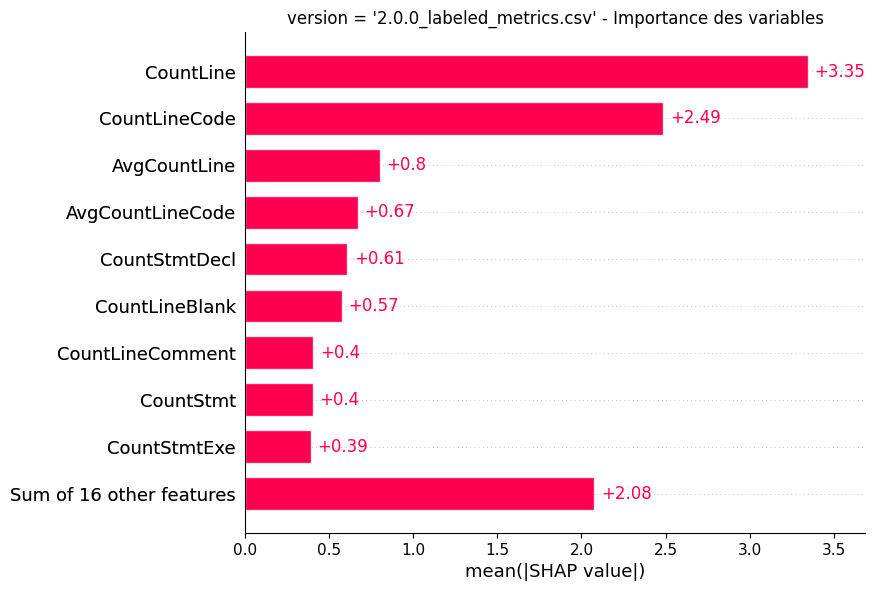

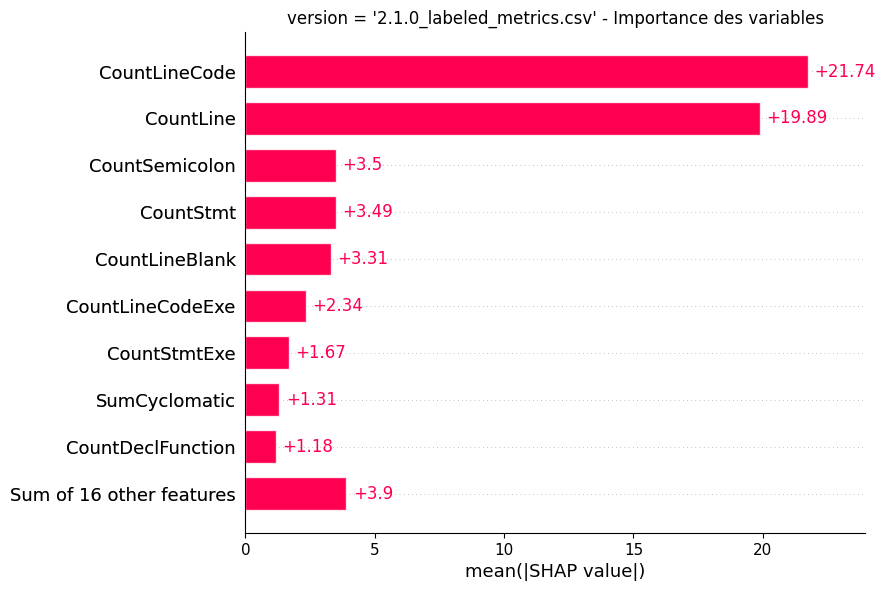

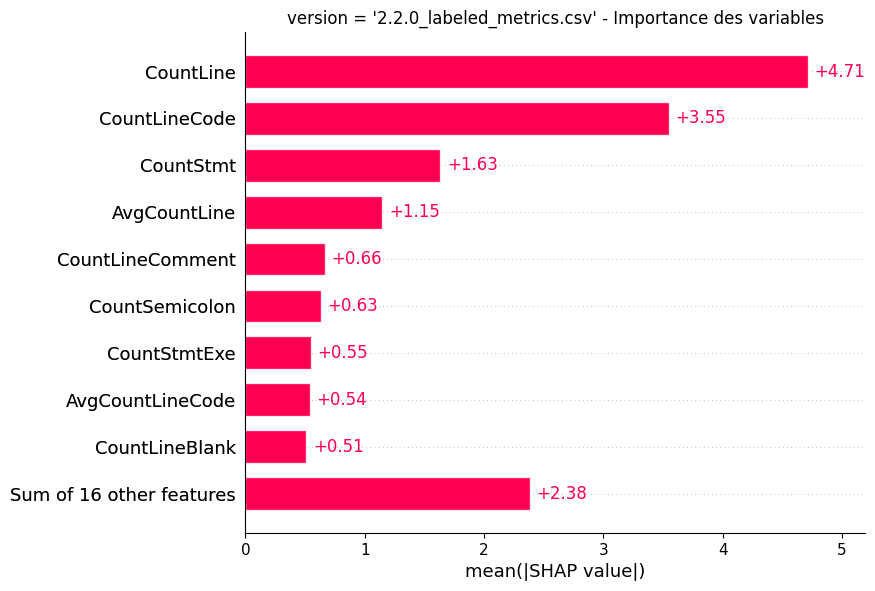

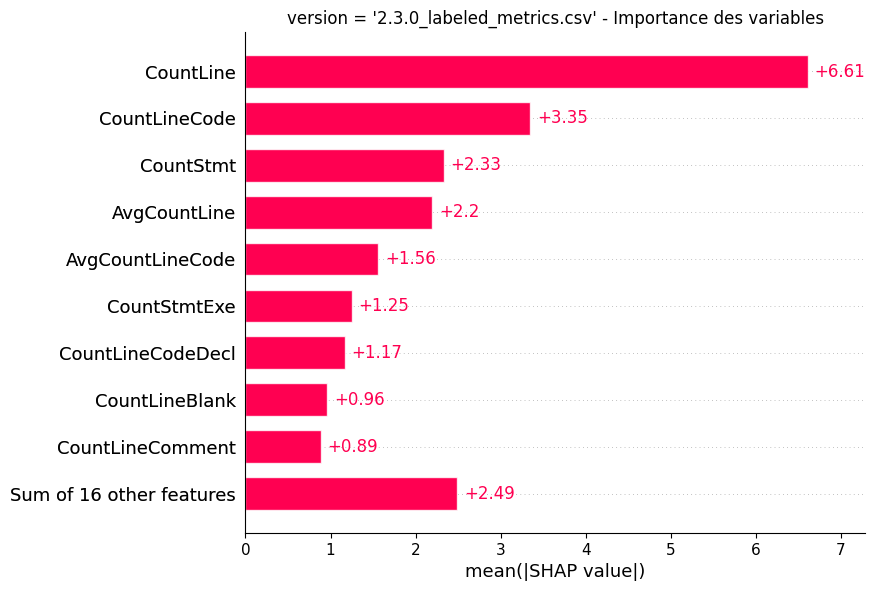

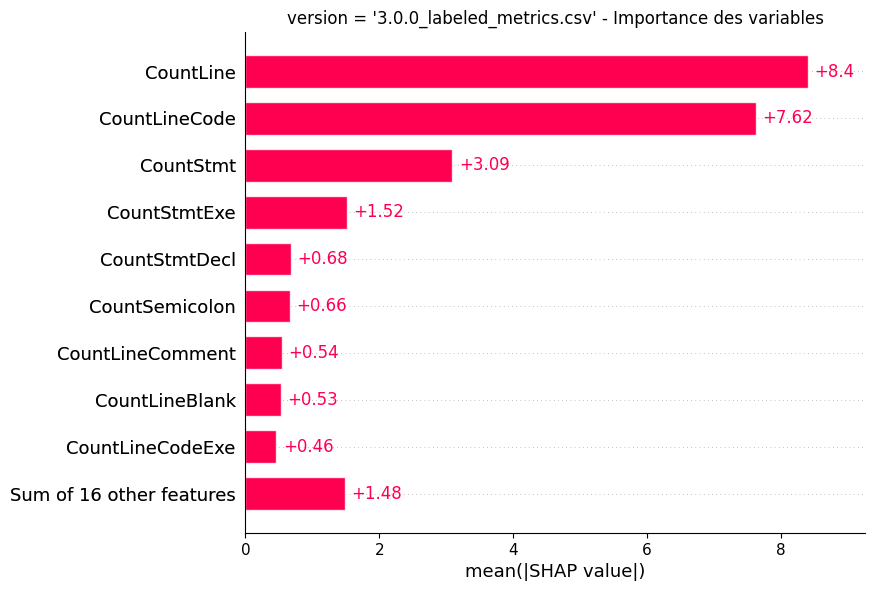

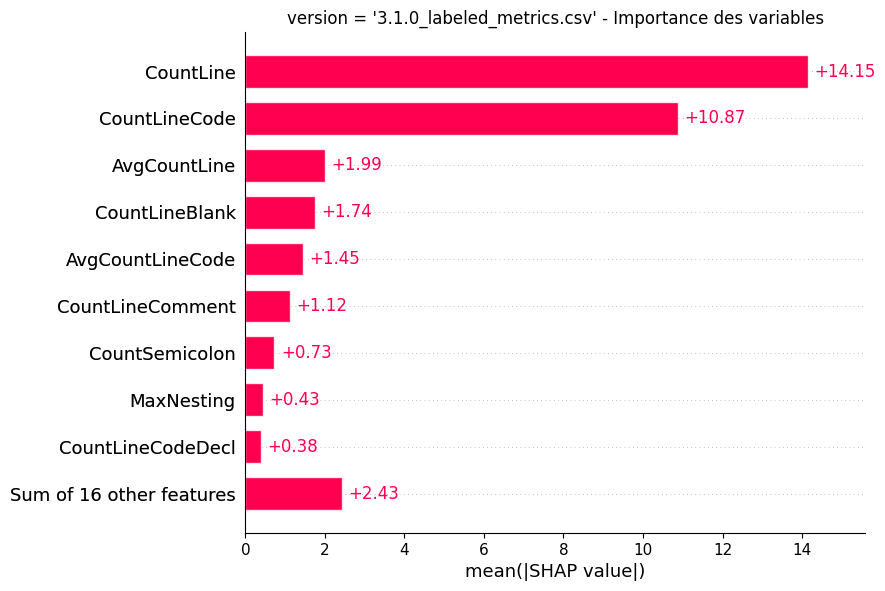

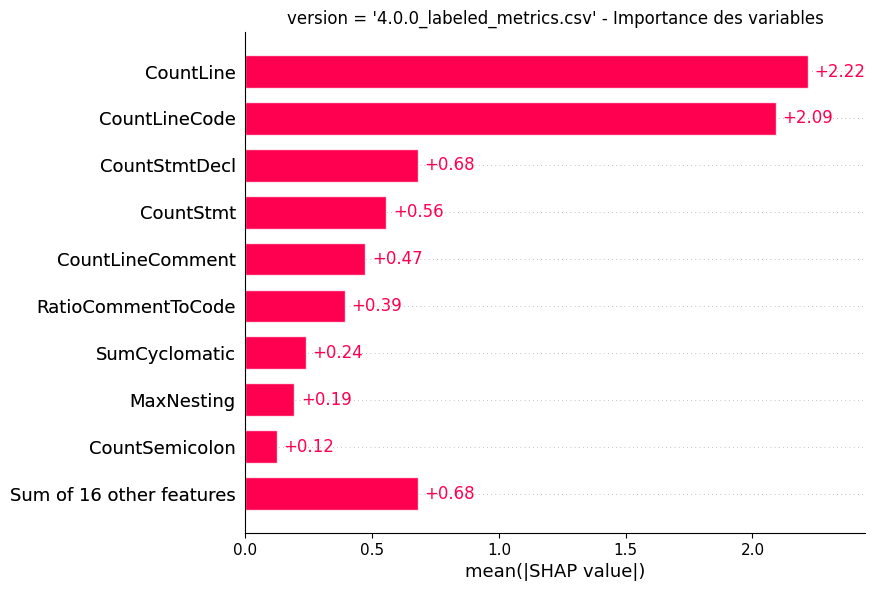

In [9]:
shap_values_versions = {}
for key in logistic_regression_models:
    shap_values = plot_SHAP(logistic_regression_models[key], XY_training_dict[key][0], XY_testing_dict[key][0], key)
    shap_values_versions[key] = shap_values

In [28]:
best_metrics = set()
metrics_values = {}
for key in shap_values_versions.keys():
    version_title = key[:3]
    shap_values = shap_values_versions[key]
    X_test = XY_testing_dict[key][0]
    # Extraire les noms des features depuis X_test
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]
    # Calculer l'importance moyenne absolue des SHAP values pour chaque feature
    shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
    # Trouver les indices des deux features les plus importantes
    top_2_indices = np.argsort(shap_mean_importance)[-5:][::-1]
    # Extraire les noms et les valeurs des deux features les plus importantes
    top_2_features = []
    for i in top_2_indices:
        top_2_features.append((feature_names[i], shap_mean_importance[i]))
        best_metrics.add(feature_names[i])
    metrics_values[version_title] = top_2_features
print(best_metrics)

#

{'CountStmtDecl', 'AvgCountLineCode', 'CountLineComment', 'CountStmtExe', 'CountLineCode', 'CountLineBlank', 'AvgCountLine', 'CountSemicolon', 'CountStmt', 'CountLine'}


C:\Users\moshi\AppData\Local\Temp\ipykernel_17384\825485850.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([row])], ignore_index=True)
C:\Users\moshi\AppData\Local\Temp\ipykernel_17384\825485850.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([row])], ignore_index=True)
C:\Users\moshi\AppData\Local\Temp\ipykernel_17384\825485850.py:7: FutureWarning: The behavior of DataFrame concatenation w

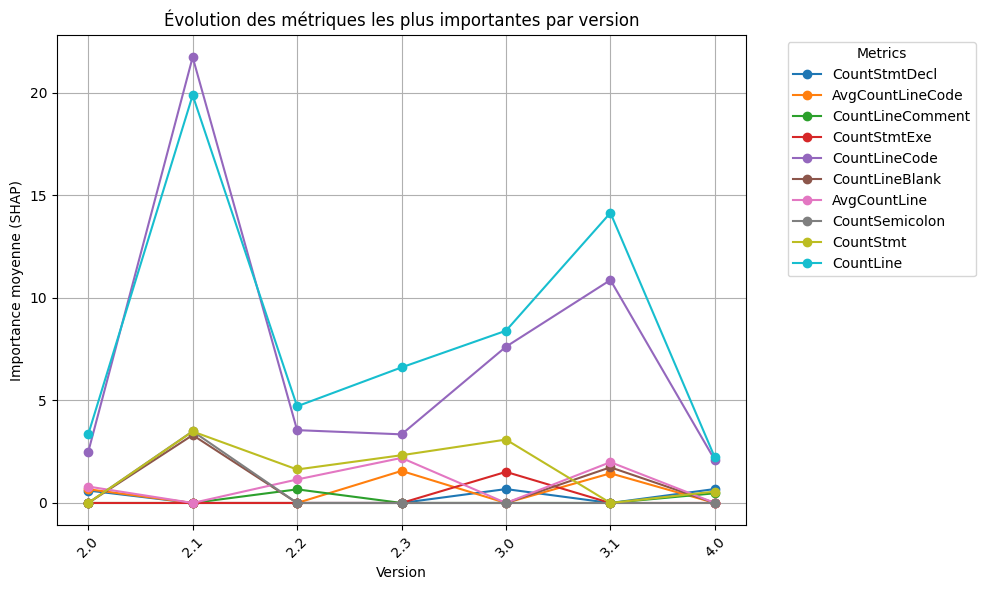

In [29]:
# Créer un DataFrame pour organiser les données
df_metrics = pd.DataFrame(columns=['version'] + list(best_metrics))
for version, features in metrics_values.items():
    row = {'version': version}
    for metric_name, metric_value in features:
        row[metric_name] = metric_value
    df_metrics = pd.concat([df_metrics, pd.DataFrame([row])], ignore_index=True)
df_metrics = df_metrics.fillna(0)

# Tracer le graphique
plt.figure(figsize=(10, 6))
for metric in best_metrics:
    if metric in df_metrics:
        plt.plot(
            df_metrics['version'],
            df_metrics[metric],
            label=metric,
            marker='o'
        )

# Ajouter des détails au graphique
plt.xlabel('Version')
plt.ylabel('Importance moyenne (SHAP)')
plt.title('Évolution des métriques les plus importantes par version')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Sauvegarder et afficher le graphique
plt.savefig('metrics_evolution_plot.png')
plt.show()